In [1]:

# Custom functions
from my_functions import *

from matplotlib import pyplot
import pickle

# ML packages
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, cross_validate, ShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,precision_recall_curve, auc, roc_auc_score, cohen_kappa_score

#from scipy.sparse import hstack
from xgboost import XGBClassifier

# Used for SMOTE:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


#### Import data

In [2]:
# import Pickled data
infile = open('bk_data_merged','rb')
df_merge = pickle.load(infile)
infile.close()
print(len(df_merge))

269


## 1) Sentiment Analysis
#### Labelling the reviews 
We will use the original (un-untransformed) reviews attribute for the sentiment analysis

In [3]:
# Determine Sentiment of Reviews; see (Hutto, n.d.)
df_merge['sentiment'] = df_merge['review'].apply(lambda x: sid_analyser(x, True))
df_merge['sentiment_all'] = df_merge['review'].apply(lambda x: sid_analyser(x, False))

# Split overall scores into seperate columns for plotting
df_merge['sentiment_pos'] = df_merge['sentiment'].apply(lambda x: x['pos'])
df_merge['sentiment_neg'] = df_merge['sentiment'].apply(lambda x: x['neg'])
df_merge['sentiment_neu'] = df_merge['sentiment'].apply(lambda x: x['neu'])
df_merge['sentiment_comp'] = df_merge['sentiment'].apply(lambda x: x['compound'])

# Apply overall sentiment classification label
df_merge['sentiment_overall'] = df_merge['sentiment'].apply(lambda x: sentiment_overall(x['compound']))

df_merge.head(2)

,title,year,genre,movie_description,critical_consensus,review,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall
0,The Hunger Games: Catching Fire,2013,"[Adventure, Sci-Fi, Action]",After arriving safely home from their unpreced...,"Smart, smoothly directed, and enriched with a ...","[Catching Fire delivers on the grim, roiling p...","{'neg': 0.105, 'neu': 0.65, 'pos': 0.246, 'com...","[{'neg': 0.339, 'neu': 0.389, 'pos': 0.272, 'c...",0.246,0.105,0.650,0.9986,positive
1,The Hunger Games: Mockingjay – Part 1,2014,"[Action, Adventure, Sci-Fi]",Following her rescue from the devastating Quar...,The Hunger Games: Mockingjay - Part 1 sets up ...,"[""Mockingjay - Part 1,"" however well done, can...","{'neg': 0.039, 'neu': 0.771, 'pos': 0.19, 'com...","[{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'com...",0.190,0.039,0.771,0.9974,positive


In [4]:
# note the data are imbalanced
df_merge['sentiment_overall'].value_counts()

positive    233
negative     35
neutral       1
Name: sentiment_overall, dtype: int64

Text(0.5, 1.0, 'Compound Sentiment')

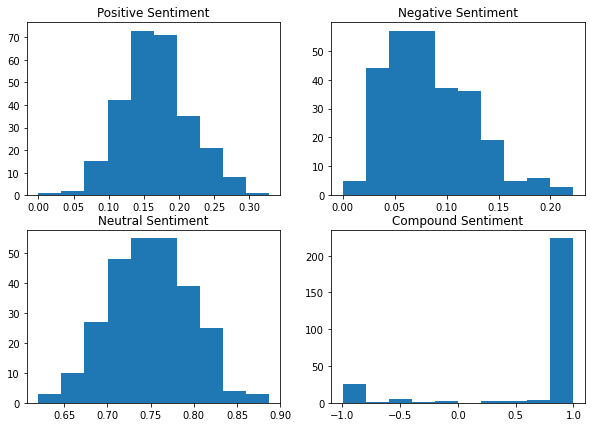

In [5]:
fig, axs = plt.subplots(2, 2, figsize = (10,7))

# Plot the distribution of sentiment
axs[0,0].hist(df_merge['sentiment_pos'])
axs[0,0].set_title("Positive Sentiment")
axs[0,1].hist(df_merge['sentiment_neg'])
axs[0,1].set_title("Negative Sentiment")
axs[1,0].hist(df_merge['sentiment_neu'])
axs[1,0].set_title("Neutral Sentiment")
axs[1,1].hist(df_merge['sentiment_comp'])
axs[1,1].set_title("Compound Sentiment")

**What is the neutral review?**

It looks like the reviews are balanced between positive and negative. As this is the only film that VADER has classified as neutral, we will remove it from the dataset.

In [6]:
# What is the neutral review?
print('Film: ', df_merge[df_merge['sentiment_overall'] == 'neutral']['title'].values)

Film:  ['Thunderball']


In [7]:
# How are the reviews scored individually?
df_merge.head()

sent = []
for i in list(df_merge[df_merge['sentiment_overall'] == 'neutral']['sentiment_all'])[0]:
    sent.append([i['compound'], sentiment_overall(np.mean(i['compound']))])
    
pd.DataFrame(sent)[1].value_counts()

positive    5
negative    3
Name: 1, dtype: int64

In [8]:
# Classify as positive
df_merge.loc[df_merge.title == 'Thunderball', 'sentiment_overall'] = 'positive'

In [9]:
# note the data are imbalanced
df_merge['sentiment_overall'].value_counts()

positive    234
negative     35
Name: sentiment_overall, dtype: int64

## 2) Construct final data model
### Data Cleanup

In [10]:
df_merge.head(2)

,title,year,genre,movie_description,critical_consensus,review,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall
0,The Hunger Games: Catching Fire,2013,"[Adventure, Sci-Fi, Action]",After arriving safely home from their unpreced...,"Smart, smoothly directed, and enriched with a ...","[Catching Fire delivers on the grim, roiling p...","{'neg': 0.105, 'neu': 0.65, 'pos': 0.246, 'com...","[{'neg': 0.339, 'neu': 0.389, 'pos': 0.272, 'c...",0.246,0.105,0.650,0.9986,positive
1,The Hunger Games: Mockingjay – Part 1,2014,"[Action, Adventure, Sci-Fi]",Following her rescue from the devastating Quar...,The Hunger Games: Mockingjay - Part 1 sets up ...,"[""Mockingjay - Part 1,"" however well done, can...","{'neg': 0.039, 'neu': 0.771, 'pos': 0.19, 'com...","[{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'com...",0.190,0.039,0.771,0.9974,positive


In [11]:
# Clean text
# 1) Remove non-letters
# 2) Remove stop words for descriptions and reviews
# 3) Lemmatize text for descriptions and reviews
df_merge['movie_description'] = df_merge['movie_description'].apply(lambda x: clean_text(x, True)) 
df_merge['critical_consensus'] = df_merge['critical_consensus'].apply(lambda x: clean_text(x, True))
df_merge['review_list'] = df_merge['review'].apply(lambda x: clean_text_list(x, True)) 
df_merge['reviews'] = df_merge['review_list'].apply(lambda x: ', '.join(x))

# convert to lower case
df_merge['genre'] = df_merge['genre'].apply(lambda x: '| '.join(x).lower().split('| '))
#df_merge['genre'] = df_merge['genre'].apply(lambda x: x.lower().split(', '))

df_merge.head(3)

,title,year,genre,movie_description,critical_consensus,review,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall,review_list,reviews
0,The Hunger Games: Catching Fire,2013,"[adventure, sci-fi, action]",arriving safely home unprecedented victory th ...,smart smoothly directed enriched deeper explor...,"[Catching Fire delivers on the grim, roiling p...","{'neg': 0.105, 'neu': 0.65, 'pos': 0.246, 'com...","[{'neg': 0.339, 'neu': 0.389, 'pos': 0.272, 'c...",0.246,0.105,0.650,0.9986,positive,[catching fire delivers grim roiling promises ...,catching fire delivers grim roiling promises o...
1,The Hunger Games: Mockingjay – Part 1,2014,"[action, adventure, sci-fi]",following rescue devastating quarter quell kat...,hunger games mockingjay part sets franchise fi...,"[""Mockingjay - Part 1,"" however well done, can...","{'neg': 0.039, 'neu': 0.771, 'pos': 0.19, 'com...","[{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'com...",0.190,0.039,0.771,0.9974,positive,[mockingjay part however well done cant compet...,mockingjay part however well done cant compete...
3,Forrest Gump,1994,"[comedy, drama & romance]",slow witted forrest gump tom hanks never thoug...,forrest gump may overly sentimental film somew...,"[A dark and driven work, haunted by violence, ...","{'neg': 0.087, 'neu': 0.723, 'pos': 0.19, 'com...","[{'neg': 0.597, 'neu': 0.403, 'pos': 0.0, 'com...",0.190,0.087,0.723,0.9968,positive,[dark driven work haunted violence cruelty sen...,dark driven work haunted violence cruelty sens...


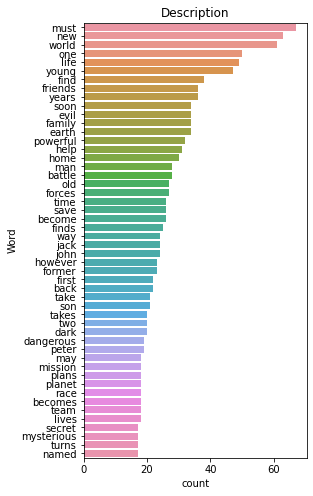

In [12]:
freq_words_chart(df_merge['movie_description'], 50, 'Description', 4)

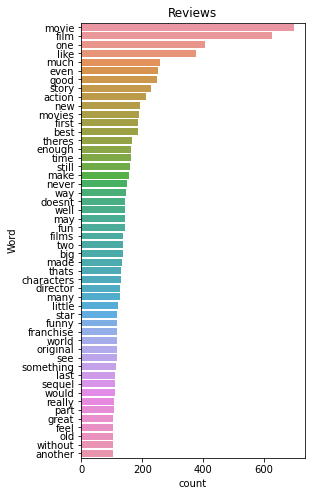

In [13]:
freq_words_chart(df_merge['reviews'], 50, 'Reviews', 4)

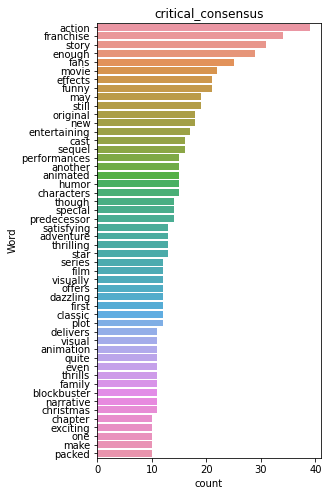

In [14]:
freq_words_chart(df_merge['critical_consensus'], 50, 'critical_consensus', 4)

Text(0.5, 1.0, 'Description word count distribution')

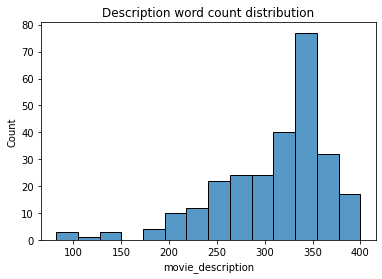

In [15]:
des_len = df_merge['movie_description'].apply(lambda x: len(x))
sns.histplot(des_len)
plt.title('Description word count distribution')

Text(0.5, 1.0, 'Review word count distribution')

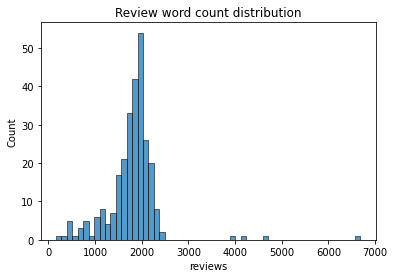

In [16]:
rev_len = df_merge['reviews'].apply(lambda x: len(x))
sns.histplot(rev_len)
plt.title('Review word count distribution')

Text(0.5, 1.0, 'Review word count critical_consensus')

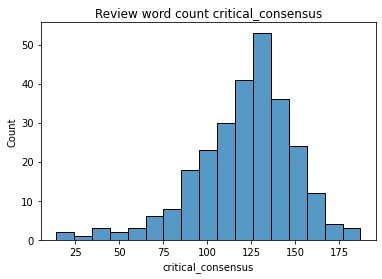

In [17]:
rev_len = df_merge['critical_consensus'].apply(lambda x: len(x))
sns.histplot(rev_len)
plt.title('Review word count critical_consensus')

#### Final Dataframe
Remove columns:
* **review:** original review data
* **worldwide_gross**: not important for this model
* **review_list:** list of cleaned review data
* **sentiment_overall, sentiment_all, sentiment_pos, sentiment_neg, sentiment_neu, sentiment_comp:** we only need sentiment 

In [18]:
df_model = df_merge.copy()

# Binary label for overall sentiment
df_model['sentiment']=df_model['sentiment_overall'].apply(lambda x: 1 if x=='positive' else 0)

# Merge title and year columns
df_model['title'] = df_model.apply(lambda x: x.title + ' (' + str(x.year) + ')', axis = 1)

# Merge X variables
df_model['text'] = (df_model["movie_description"].astype(str)
                    .str.cat(df_model["critical_consensus"], sep =" ")
                    .str.cat(df_model["reviews"], sep =" ")
                    ).str.strip()

# Final DataFrame
cols = ['title', 'genre', 'sentiment', 'text']
df_model = df_model.loc[:, cols]

df_model.head(3)

,title,genre,sentiment,text
0,The Hunger Games: Catching Fire (2013),"[adventure, sci-fi, action]",1,arriving safely home unprecedented victory th ...
1,The Hunger Games: Mockingjay – Part 1 (2014),"[action, adventure, sci-fi]",1,following rescue devastating quarter quell kat...
3,Forrest Gump (1994),"[comedy, drama & romance]",1,slow witted forrest gump tom hanks never thoug...


In [19]:
print('Number of films to model: ',len(df_model))

Number of films to model:  269


### Data Wrangling for Model

In [42]:
# Multilabel Binarizer - applied on y (target) variable
from sklearn.preprocessing import OneHotEncoder
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_model['genre'])

# transform target variable
y = multilabel_binarizer.transform(df_model['genre'])

# Transform text to non-numeric form using a TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features = 1500)

# Split into training and test data sets
X = df_model ['text']
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size = 0.2
                                                    , random_state = 0)

# Store an unaltered copy of the test data for recommender system demonstration
X_test_copy = X_test.copy()

# Create TF-IDF features
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

# Normalise X data sets
norm = Normalizer()
X_train = norm.fit_transform(X_train)
X_test  = norm.transform(X_test)

### XGBoost

In [21]:
# Create the random grid
xg_params = {
    "estimator__max_depth": [1, 3, 5, 7, 9],
    "estimator__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    "estimator__n_estimators":  [100, 200, 400, 600, 800, 1000],
    "estimator__colsample_bytree": [0.3, 0.5, 0.7],
    "estimator__gamma": [0, 1, 5],
    "estimator__subsample": [0.5 ,0.7 ,1]
}

xg_params

{'estimator__max_depth': [1, 3, 5, 7, 9],
 'estimator__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
 'estimator__n_estimators': [100, 200, 400, 600, 800, 1000],
 'estimator__colsample_bytree': [0.3, 0.5, 0.7],
 'estimator__gamma': [0, 1, 5],
 'estimator__subsample': [0.5, 0.7, 1]}

In [22]:
%%time
xgc = OneVsRestClassifier(XGBClassifier(random_state = 1, verbosity  = 0, use_label_encoder=False, n_jobs = -1))

# search across 50 different combinations, and use all available cores
# Fit the random search model
clf_xgc_random = RandomizedSearchCV(estimator = xgc
                               , param_distributions = xg_params
                               , n_iter = 50
                               , cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
                               , verbose=0
                               , random_state=1
                               , n_jobs = -1
                               , scoring = 'f1_micro'
                               , return_train_score = True)

clf_xgc_random.fit(X_train, y_train)

Wall time: 18min 12s


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
                   estimator=OneVsRestClassifier(estimator=XGBClassifier(base_score=None,
                                                                         booster=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         enable_categorical=False,
                                                                         gamma=None,
                                                                         gpu_id=None,
                                                                         importance_type=None,
                                                                        

In [23]:
# Best hyperparameter values
best_params = clf_xgc_random.best_params_
clf_xgc_random.best_params_

{'estimator__subsample': 1,
 'estimator__n_estimators': 400,
 'estimator__max_depth': 3,
 'estimator__learning_rate': 0.2,
 'estimator__gamma': 1,
 'estimator__colsample_bytree': 0.7}

In [24]:
%%time
# Fit final model with best parameter estimates
xg_final = OneVsRestClassifier(XGBClassifier( max_depth = best_params['estimator__max_depth']
                       , learning_rate = best_params['estimator__learning_rate']
                       , n_estimators = best_params['estimator__n_estimators']
                       , gamma = best_params['estimator__gamma']
                       , subsample = best_params['estimator__subsample']
                       , n_jobs = -1
                       , random_state = 1 
                       , use_label_encoder=False
                       , verbosity  = 0))

xg_final.fit(X_train, y_train )

Wall time: 4.4 s


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False, gamma=1,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2,
                                            max_delta_step=None, max_depth=3,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=400, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None

In [25]:
%%time

# Cross validated metrics
def cv_score (score, cv):
    return cross_val_score(xg_final
                        , X_train
                        , y_train
                        , cv = cv
                        , scoring = score
                        , verbose = 0
                        , n_jobs = -1)

scores_lst = []
for i in ["accuracy","f1_micro", "recall_micro", "precision_micro", "roc_auc"]:
    scores_lst.append(cv_score(i, 10))

Wall time: 2min 16s


In [26]:
# Cross validated results
cv_scores_xg = pd.DataFrame(scores_lst).transpose()
cv_scores_xg.columns = ["accuracy","f1_score", "recall_score", "precision_score", "roc_auc"]
cv_scores_xg = pd.DataFrame(cv_scores_xg.mean()).transpose()

In [27]:
# Performance on training data
y_pred_xg = xg_final.predict(X_train)
train_scores_xg = pd.DataFrame.from_dict({'accuracy' : accuracy_score(y_train, y_pred_xg)
                                 , 'f1_score': f1_score(y_train, y_pred_xg, average="micro")
                                 , 'recall_score': recall_score(y_train, y_pred_xg, average="micro")
                                 , 'precision_score': precision_score(y_train, y_pred_xg, average="micro")
                                 , 'roc_auc': roc_auc_score(y_train, y_pred_xg, average="micro")
                                }, orient = 'index').transpose()

In [46]:
# Performance on Test data
y_pred_xg_fin = xg_final.predict(X_test)
test_scores_xg = pd.DataFrame.from_dict({'accuracy' : accuracy_score(y_test, y_pred_xg_fin)
                                 , 'f1_score': f1_score(y_test, y_pred_xg_fin, average="micro")
                                 , 'recall_score': recall_score(y_test, y_pred_xg_fin, average="micro")
                                 , 'precision_score': precision_score(y_test, y_pred_xg_fin, average="micro")
                                 , 'roc_auc': roc_auc_score(y_test, y_pred_xg_fin, average="micro")
                                }, orient = 'index').transpose()

In [47]:
# Dataframe of metric scores
scores_xg = pd.concat([train_scores_xg, cv_scores_xg, test_scores_xg])
scores_xg['Scores'] = ['Training', 'CV', 'Test']
scores_xg.set_index(['Scores'])

,accuracy,f1_score,recall_score,precision_score,roc_auc
Scores,,,,,
Training,0.995349,0.999092,0.998185,1.000000,0.999093
CV,0.187662,0.682374,0.611590,0.782157,0.837679
Test,0.203704,0.714829,0.661972,0.776860,0.784434


### Example use of the recommender system

In [48]:
# Selection of filmes by genre
lst = [1,25,31,39,45] 

# Lookup reference
x_text_ref = pd.DataFrame(X_test_copy).reset_index()

# Print out predicted genres against real genres
for i in lst:
    idx = x_text_ref.loc[x_text_ref.index == i, 'index'].values[0]
    
    print ('Film: ', df_model.loc[idx,'title'] )
    print ('Sentiment of reviews: ', np.where(df_model.loc[idx,'sentiment'] == 1, 'positive', 'negative'))
    print ('Genre(s): ', multilabel_binarizer.inverse_transform(y_test)[i])
    print ('Prediction: ', multilabel_binarizer.inverse_transform(y_pred_xg_fin)[i])
    print ('------')

Film:  The Santa Clause 3: The Escape Clause (2006)
Sentiment of reviews:  positive
Genre(s):  ('comedy', 'kids, family & animation')
Prediction:  ('comedy', 'kids, family & animation')
------
Film:  Transformers: Age of Extinction (2014)
Sentiment of reviews:  positive
Genre(s):  ('action', 'adventure', 'sci-fi')
Prediction:  ('action', 'adventure', 'fantasy')
------
Film:  The Lord of the Rings: The Fellowship of the Ring (2001)
Sentiment of reviews:  positive
Genre(s):  ('adventure', 'fantasy')
Prediction:  ('action', 'adventure')
------
Film:  Signs (2002)
Sentiment of reviews:  negative
Genre(s):  ('mystery, thriller & horror', 'sci-fi')
Prediction:  ('drama & romance', 'fantasy', 'mystery, thriller & horror')
------
Film:  Jerry Maguire (1996)
Sentiment of reviews:  positive
Genre(s):  ('comedy', 'drama & romance')
Prediction:  ('comedy',)
------
